In [5]:
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime
import statistics
from sklearn import linear_model

In [6]:
def convert_datetime(dTot):
    
    dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')
    
    
    
    dTot = dTot.drop(['Date','Hour'],axis = 1)
    dTot = dTot.set_index('Date_Hour')
    
    return dTot

In [10]:
#importing zonal data from 2015-2017, only taking total consumption
demand2013 = pd.read_csv("ZonalDemands_2013.csv", usecols = [0,1,2])
demand2014 = pd.read_csv("ZonalDemands_2014.csv", usecols = [0,1,2])
demand2015 = pd.read_csv("ZonalDemands_2015.csv", usecols = [0,1,2])
demand2016 = pd.read_csv("ZonalDemands_2016.csv", usecols = [0,1,2])
demand2017 = pd.read_csv("ZonalDemands_2017.csv", usecols = [0,1,2])

#convert to pandas dateTime
demand2013 = convert_datetime(demand2013).resample('D').mean()
demand2014 = convert_datetime(demand2014).resample('D').mean()
demand2015 = convert_datetime(demand2015).resample('D').mean()
demand2016 = convert_datetime(demand2016).resample('D').mean()
demand2017 = convert_datetime(demand2017).resample('D').mean()


0.6915856461227944


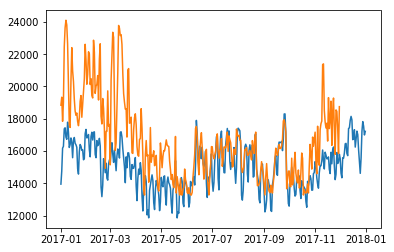

In [15]:
#weather normalize data

#importanting weather data
temp = pd.read_csv("temperature.csv", usecols = [0,26], parse_dates=["datetime"], index_col="datetime")
#convert to degrees celsius
temp = temp - 273.15

#calcualte HDD/CDD
talpha = 14 #temp where correlation between temperature and demand inverts
tbeta = 14

temp['CDD'] = (((temp['Toronto'].resample('D').max()+temp['Toronto'].resample('D').min())/2-talpha))
temp['HDD'] = ((tbeta-(temp['Toronto'].resample('D').max()+temp['Toronto'].resample('D').min())/2))
temp.CDD[temp.CDD < 0] = 0
temp.HDD[temp.HDD < 0] = 0

#build baseline equation
total = pd.concat([demand2016])
total = pd.merge(total,temp,how='inner', left_index=True, right_index=True)
X1 = total.drop(['Total','Toronto'],axis = 1)
Y =  total['Total']
clf = linear_model.Lasso(alpha = 0.1) #.LinearRegression()
clf.fit(X1, Y)
print(clf.score(X1,Y))

baseline = clf.coef_[0]*temp['CDD'] + clf.coef_[0]*temp['HDD'] + clf.intercept_



plt.plot(demand2017['2017'])
plt.plot(baseline['2017'])